# Detecting Gravitional Waves Using Topological algorithms

Authors:
* Christian Jaffé Alarcón Acosta - A00832881
* José Andrés Orantes Guillén - A01174130
* Juan José Montes Raygoza - A00834630
* Pedro Fernández Merino - A01733006
* Rubén Darío Castro Terrazas - A00833945



### Import libraries and dependencies

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from data.generate_datasets import make_gravitational_waves
from pathlib import Path
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.cm as cm
import gudhi as gd
from sklearn.decomposition import PCA
from nolitsa import dimension, delay
from gtda.plotting import plot_point_cloud
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
import matplotlib.patches as patches
plt.rcParams.update(plt.rcParamsDefault) #Permitir Latex
import kmapper as km
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

sb.set(style="whitegrid")


### Motivation


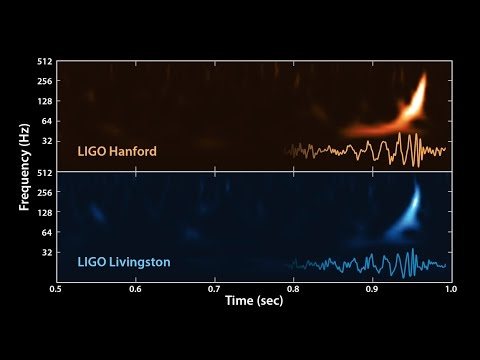

In [2]:
from IPython.display import YouTubeVideo

YouTubeVideo("Y3eR49ogsF0", width=600, height=400)
YouTubeVideo("QyDcTbR-kEA", width=600, height=400)

### Generate the data

The data was obtanined from the giotto-tda library: https://github.com/giotto-ai/giotto-tda/blob/master/examples/gravitational_waves_detection.ipynb

In the article, the authors create a synthetic training set as follows: 

* Generate gravitational wave signals that correspond to non-spinning binary black hole mergers
* Generate a noisy time series and embed a gravitational wave signal with probability 0.5 at a random time.

The result is a set of time series of the form

$$ s = g + \epsilon \frac{1}{R}\xi $$

where $g$ is a gravitational wave signal from the reference set, $\xi$ is Gaussian noise, $\epsilon=10^{-19}$ scales the noise amplitude to the signal, and $R \in (0.075, 0.65)$ is a parameter that controls the signal-to-noise-ratio (SNR).

In [3]:

R = 0.65
n_signals = 100
DATA = Path("./data")

noisy_signals, gw_signals, labels = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, r_min=R, r_max=R, n_snr_values=1
)

print(f"Number of noisy signals: {len(noisy_signals)}")
print(f"Number of timesteps per series: {len(noisy_signals[0])}")

Number of noisy signals: 100
Number of timesteps per series: 8692


Plot the data (gravitational waves)

In [4]:
# get the index corresponding to the first pure noise time series
background_idx = np.argmin(labels)
# get the index corresponding to the first noise + gravitational wave time series
signal_idx = np.argmax(labels)

ts_noise = noisy_signals[background_idx]
ts_background = noisy_signals[signal_idx]
ts_signal = gw_signals[signal_idx]

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_noise))), y=ts_noise, mode="lines", name="noise"),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=list(range(len(ts_background))),
        y=ts_background,
        mode="lines",
        name="background",
    ),
    row=1,
    col=2,
)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_signal))), y=ts_signal, mode="lines", name="signal"),
    row=1,
    col=2,
)
fig.show()

### Encaje de Takens

#### Parámetros óptimos de $\tau$ y $d$

* $\tau$: tiempo de retardo
* $d$: dimensión 

In [23]:
ts_noise.shape #dimension de los datos con ruido
maxTau =  int(round(np.sqrt(ts_noise.shape[0]),0))

In [24]:
def find_optimal_delay(x, maxtau):
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)
    return int(np.where(diffmi > 0)[0][0]) #returns the first element in which the difference is greater than 0. It means that gives you the local optimal
    #print(np.where(diffmi > 0))

In [30]:
tau_ts_noise  = find_optimal_delay(ts_noise,maxtau=maxTau) #ejemplo
print(f'El óptimo local para los datos con ruido es 1: {delay_ts_noise}')

El óptimo local para los datos con ruido es 1: 1


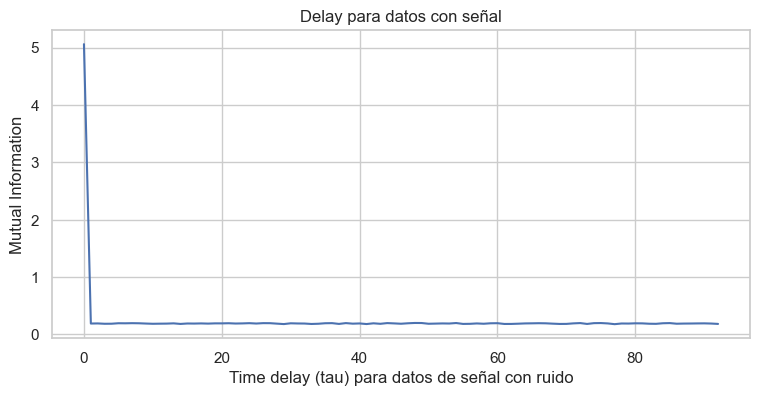

In [28]:
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau) para datos de señal con ruido')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(ts_noise, maxtau=maxTau))
plt.title("Delay para datos con señal")
plt.show()

In [29]:
def find_optimal_dimension(y,tau):
    dim =  np.arange(1,10)
    f1, f2, f3 = dimension.fnn(y, tau=tau, dim=dim)
    diff_f1 = np.diff(f1)
    #print(f1)
    optimal_d = int(np.where(diff_f1 == 0)[0][0]) 

    #changeOf_diff_f1 = np.diff(diff_f1) 
    #optimal_dimension = np.argmax(changeOf_diff_f1) + 2
    return optimal_d


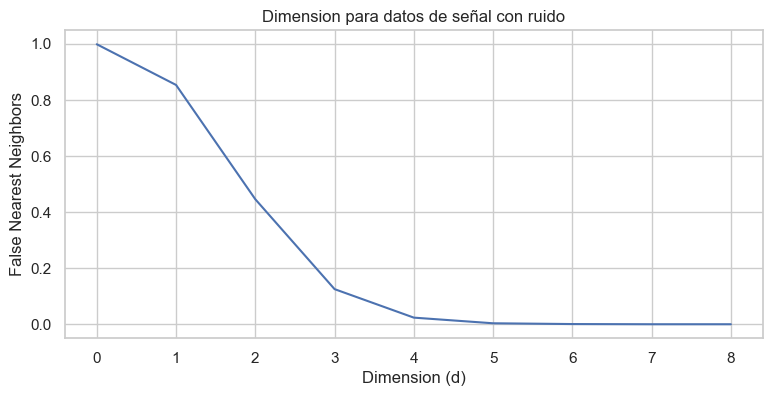

d:  7


In [31]:
dim = np.arange(1, 10)
f1, f2, f3 = dimension.fnn(ts_noise, tau=tau_ts_noise, dim=dim) #Ejemplo

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors')
plt.title("Dimension para datos de señal con ruido")
plt.plot(f1)
plt.show()
print("d: ",find_optimal_dimension(ts_noise,tau_ts_noise))

Vamos a elegir la dimension 3.

### Aplicar el Encaje

In [39]:
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=1, dimension=3, stride=stride
)

y_gw_embedded = embedder.fit_transform(ts_noise)

In [40]:
#visualizacion
print(f"Shape of embedded time series: {y_gw_embedded.shape}")
plot_point_cloud(y_gw_embedded)

Shape of embedded time series: (1739, 2)


### Analisis de persistencia

### Mapper